In [1]:
import numpy as np
data = np.genfromtxt('DataPool.csv', delimiter=',')
data = data[~np.isnan(data)].reshape(-1,12) # import data

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
min_max_scaler = MinMaxScaler().fit(data)

In [4]:
norm_data = min_max_scaler.transform(data) # perform minMaxscale as suggested by the paper

In [5]:
X = norm_data[:,:11]
y = norm_data[:, 11]

## Max yield

In [6]:
from sklearn.ensemble import RandomForestRegressor
from modAL.uncertainty import uncertainty_sampling
from modAL.models import ActiveLearner
from sklearn.metrics import r2_score
import copy

In [7]:
class rfwapper(RandomForestRegressor):
    def predict(self, X, return_std = False):
        if return_std:
            ys = np.array([e.predict(X) for e in self.estimators_])
            return np.mean(ys, axis = 0).ravel(), (np.std(ys, axis = 0).ravel() + 1e-6)
        return super().predict(X).ravel()
    
def init_training(size, total):
    sample_idxs = np.arange(0,total)
    np.random.shuffle(sample_idxs)
    return sample_idxs[:size]

def max_yeild_query(model, X, size, a_keyword_argument=42):
    mean, std = model.predict(X, return_std=True)
    UCB = mean + np.sqrt(2.0) * std
    return np.argsort(UCB)[-size:]

In [31]:
X_random = copy.deepcopy(X)
y_random = copy.deepcopy(y)

size = 102
idxs = init_training(size, X.shape[0])

regressor = ActiveLearner(
    estimator=rfwapper(),
    query_strategy=max_yeild_query,
    X_training=X_random[idxs].reshape(size, -1),
    y_training=y_random[np.array(idxs)].reshape(size),
)

running_sum = min_max_scaler.inverse_transform(np.hstack((X_random[idxs], y_random[idxs].reshape(size,1))))[:,11].sum()
print("[INIT]\trunning mean:\t%.4f" %(running_sum / size))

means = [running_sum / size] #only for plotting
points = [min_max_scaler.inverse_transform(np.hstack((X_random[idxs], y_random[idxs].reshape(size,1))))[:,11]] #only for plotting

X_random, y_random = (np.delete(X_random, idxs, axis=0), np.delete(y_random, idxs))

n_queries = 510 - size
for idx in range(n_queries // size):
    query_idx,_ = regressor.query(X_random, size)
    regressor.teach(X_random[query_idx].reshape(size, -1), y_random[np.array(query_idx)].reshape(size))
    inverse_norm = min_max_scaler.inverse_transform(np.hstack((X_random[query_idx], y_random[query_idx].reshape(size,1))))
    running_sum += inverse_norm[:,11].sum()
    print("[%d/%d]\trunning mean:\t%.4f" %(idx+1, n_queries//size, running_sum / (idx+2) / size))
    means.append(running_sum / (idx+2) / size) #only for plotting
    points.append(inverse_norm[:,11]) #only for plotting
    X_random, y_random = (np.delete(X_random, query_idx, axis=0), np.delete(y_random, query_idx))

[INIT]	running mean:	12.9256
[1/4]	running mean:	17.8757
[2/4]	running mean:	20.0473
[3/4]	running mean:	19.9078
[4/4]	running mean:	19.3942


Text(0, 0.5, 'selected sample yields')

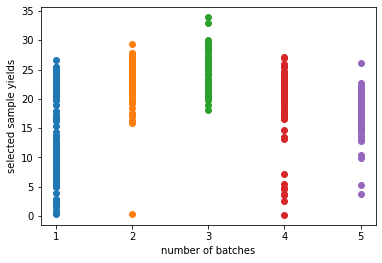

In [34]:
fig, ax = plt.subplots()
for j in [1,2,3,4,5]:
    ax.scatter([j] * points[j-1].shape[0], points[j-1])
ax.set_xticks([1,2,3,4,5])
ax.set_xlabel("number of batches")
ax.set_ylabel("selected sample yields")

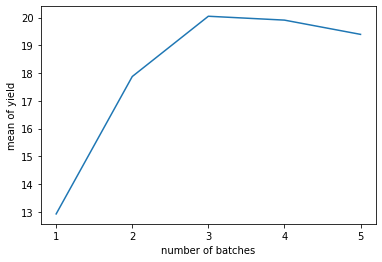

In [33]:
fig, ax = plt.subplots()
ax.plot([1,2,3,4,5], means)
ax.set_xlabel("number of batches")
ax.set_ylabel("mean of yield")
ax.set_xticks([1,2,3,4,5])

### Max accuracy

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [15]:
X_active = X.copy()
y_active = y.copy()

size = 102
num_regressor = 3
idxs = init_training(size, X.shape[0])
learners = []
for i in range(num_regressor):
    l = ActiveLearner(
        estimator=GradientBoostingRegressor(),
        X_training=X_active[idxs[i * size // num_regressor:(i+1) * size // num_regressor]].reshape(size//num_regressor, -1), 
        y_training=y_active[idxs[i * size // num_regressor:(i+1) * size // num_regressor]].reshape(size//num_regressor),
    )
    learners.append(l)
    
X_active, y_active = (np.delete(X_active, idxs, axis=0), np.delete(y_active, idxs))

committee = CommitteeRegressor(
    learner_list = learners,
    query_strategy = max_std_sampling,
)

iters = []
r2_tests = []

n_queries = 510 - size
for idx in range(n_queries):
    query_idx,_ = committee.query(X_active)
    committee.teach(X_active[query_idx].reshape(1, -1), y_active[np.array(query_idx)].reshape(1))
    X_active, y_active = (np.delete(X_active, query_idx, axis=0), np.delete(y_active, query_idx))
    
    if idx % 50 == 0:
        y_pred_final = committee.predict(X_active, return_std = False)
        r2_test = r2_score(y_active, y_pred_final)
        print("[%d/%d]\tR2 test:\t%.4f" %(idx, n_queries, r2_test))
        iters.append(size+idx+1)
        r2_tests.append(r2_test)
        

y_pred_final = committee.predict(X_active, return_std = False)
r2_test = r2_score(y_active, y_pred_final)
iters.append(510)
r2_tests.append(r2_test)

# print(y_test,y_pred_final,y_train_pred)
print("R2 test:\t %.4f" %(r2_test))

[0/408]	R2 test:	0.7707
[50/408]	R2 test:	0.8819
[100/408]	R2 test:	0.9017
[150/408]	R2 test:	0.9093
[200/408]	R2 test:	0.9118
[250/408]	R2 test:	0.9112
[300/408]	R2 test:	0.9146
[350/408]	R2 test:	0.9184
[400/408]	R2 test:	0.9190
R2 test:	 0.9184


In [16]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'number of selected samples')

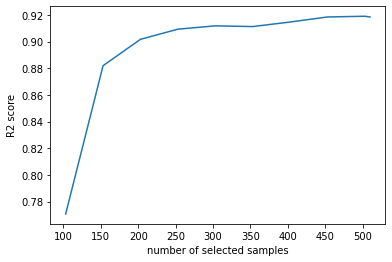

In [26]:
fig, ax = plt.subplots()
ax.plot(iters, r2_tests)
ax.set_ylabel("R2 score")
ax.set_xlabel("number of selected samples")